In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch as torch
import torchvision as tv
from functools import partial
import os
import tempfile
from pathlib import Path
import fsspec
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

c:\Users\joey5\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import pyarrow.fs
import ray
from ray import tune
import ray.train as train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.load_data()

    def load_data(self):
        # Assuming a structure where each class has its own subdirectory
        for label, class_dir in enumerate(os.listdir(self.data_dir)):
            class_path = os.path.join(self.data_dir, class_dir)
            for count, img_name in enumerate(os.listdir(class_path)):
                # if count > 700:
                #     break
                img_path = os.path.join(class_path, img_name)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
def load_custom_data(data_dir="./data", batch_size=1):
    transform = transforms.Compose([
        # transforms.RandomRotation(15),
        # transforms.RandomAffine(
        #     degrees=0,
        #     translate=(0.01, 0.12),
        #     shear=(0.01, 0.03),
        # ),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    train_dir = f"{data_dir}/train"
    test_dir = f"{data_dir}/test"
    
    trainset = EmotionDataset(data_dir=train_dir, transform=transform)
    testset = EmotionDataset(data_dir=test_dir, transform=transform)

    return trainset, testset

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [6]:
# Can be used for any Image Classification task

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        # loss = F.nll_loss(outputs, labels) # Convert for problem at hand
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc.detach()}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            acc_ = 'val_acc'
        else:
            loss_ = 'loss'
            acc_ = 'acc'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x[f'{acc_}'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {f'{loss_}': epoch_loss.detach().item(), f'{acc_}': epoch_acc.detach().item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs} loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n")

In [7]:
class EmotionRecognition(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2), # output: 128 x 6 x 6

            nn.Conv2d(128, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2), # output: 64 x 12 x 12

            nn.Conv2d(64, 32, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2), # output: 32 x 24 x 24

            nn.Flatten(), 
            nn.Linear(32*6*6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 7))
        
    def forward(self, xb):
        return self.network(xb)

    def __repr__(self):
        return f"{self.network}"
    
    def __str__(self):
        summary(self.network, (1, 48, 48))

In [8]:
# print(EmotionRecognition())

In [9]:
@torch.no_grad()
def evaluate(model: object, val_loader: object) -> dict:
    '''
        Evaluate model on the validation set
        Input:
            model: training model object
            val_loder: validation data loader object
        Output:
            validation metrics
    '''

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer: object) -> float:
    ''' Returns current learning rate'''

    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_model(model: object, 
              epochs: int, 
              lr: float, 
              train_loader: object, 
              val_loader: object,
              weight_decay: float=0, 
              grad_clip: float=None, 
              opt_func: object=torch.optim.SGD):
    '''
        This function is responsible for training our model.
        We use a One Cycle learning rate policy to update our learning rate 
        with each epoch.
        The best model is saved during each epoch.
        Input:
            model_name: str 
            model: object
            epochs: int -> Max epochs
            lr: float -> Maximum allowed learning rate during learning
            train_loader: training set data loader
            val_loader: validation set data loader
            weight_decay: float -> value to decrease weights during training of each batch
            grad_clip: float -> maximum allowed gradient value
            opt_func: optimzer object
        Output:
            history: list of metrics
    '''

    model_name = "test_model"
    BEST_VAL_SCORE = 0.0 # for keeping track of best model score
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, lr=lr,
    #                                                 epochs=epochs, 
    #                                                 steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        train_history = []
        # lrs = []

        # Training Phase 
        model.train()
        for batch in tqdm(train_loader, ascii=True, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # lrs.append(get_lr(optimizer))
            # scheduler.step()


        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        # result['lrs'] = lrs
        model.epoch_end(epoch, result, epochs)

        # Save the best model
        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_acc'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history

@torch.no_grad()
def generate_prediction(model, data,extract=False) -> None:
    '''Generate prediction on the test set'''

    # load test dataset
    test_dl = DataLoader(data, batch_size=1, shuffle=True)

    # generate prediction using the validation step method defined in Base class
    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in test_dl]
        metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)
        
        
    if extract==False:
        print(f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, Accuracy: {round(metrics['val_acc'], 3)}")
    else:
        return metrics
    

In [10]:
def end_to_end(trainset, testset, parameters: dict=None) -> dict:
    '''
        A simple function end-to-end training and testing on the selected model.
        Inputs:
            model_name: str -> chosen model name
            parameters: dict -> dictionary of hyperparameters for the model
        Outputs:
            history: dict -> dictionary containing model metrics(loss, score, lr)

    '''
    torch.cuda.empty_cache()

    # hyperparameters
    BATCH_SIZE = parameters["batch_size"]
    epochs = parameters["epochs"]
    lr = parameters["lr"]
    weight_decay = parameters["weight_decay"]
    grad_clip = parameters["grad_clip"]
    opt_func = parameters["opt_func"]

    # get transformed dataset
    train_dl = DataLoader(trainset, BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(testset, BATCH_SIZE, shuffle=True)

    # # Print batch img shape, label and plot image:
    # img, label = next(iter(train_dl))
    # print(f"Batch Shape: {img.shape}")
    # print(f"Label: {label}")
    # plt.imshow(img[0].numpy().squeeze(), cmap='gray')
    # plt.show()

    # get model
    model = EmotionRecognition()

    # move model to GPU
    # model = to_device(model, device)
    
    # train model
    history = fit_model(
                model, 
                epochs, 
                lr, 
                train_dl, 
                valid_dl,
                weight_decay, 
                grad_clip, 
                opt_func
            )

    # cleaning
    torch.cuda.empty_cache()

    # generate predictions
    print("Generating predictions on the Test set")
    pred = generate_prediction(model, testset)
    return history, pred

In [11]:
training_parameters = {
    "epochs": 5,
    "lr": 3e-4,
    "weight_decay": 0.05,
    "grad_clip": 0.5e-2,
    "opt_func": torch.optim.SGD,
    "batch_size": 32,
    "momentum": 0.9

}

In [12]:
trainset, testset = load_custom_data(data_dir="C:/Users/joey5/OneDrive/KU/Fourth Year/AppML/Final_Project", batch_size=1)


In [14]:
# train the model
history,pred = end_to_end(trainset, testset, training_parameters)

Epoch: 1/5: 100%|##########| 898/898 [07:04<00:00,  2.12it/s]


Epoch: 1/5 loss: 1.9349, acc: 0.1662, val_loss: 1.8875, val_acc: 0.2407



'rm' is not recognized as an internal or external command,
operable program or batch file.
Epoch: 2/5: 100%|##########| 898/898 [07:58<00:00,  1.88it/s]


Epoch: 2/5 loss: 1.8632, acc: 0.2511, val_loss: 1.8407, val_acc: 0.2523



'rm' is not recognized as an internal or external command,
operable program or batch file.
Epoch: 4/5:   0%|          | 0/898 [00:00<?, ?it/s]

Epoch: 3/5 loss: 1.8259, acc: 0.2533, val_loss: 1.8158, val_acc: 0.2485



Epoch: 5/5:   0%|          | 0/898 [00:00<?, ?it/s]

Epoch: 4/5 loss: 1.8029, acc: 0.2523, val_loss: 1.7968, val_acc: 0.2485



Epoch: 5/5: 100%|##########| 898/898 [06:44<00:00,  2.22it/s]


Epoch: 5/5 loss: 1.7867, acc: 0.2530, val_loss: 1.7838, val_acc: 0.2492

Generating predictions on the Test set
Test Scores:
 Loss: 1.784, Accuracy: 0.25


In [ ]:
# Load the model
model = EmotionRecognition()
model.load_state_dict(torch.load("test_model_epoch-5_score-0.2557.pth"))



# 


Test Scores:
 Loss: 1.769, Accuracy: 0.255


In [ ]:

def plot_confusion_matrix(cm, class_names):
    figure, ax = plt.subplots(figsize=(5, 5))
    cm_norm = cm / np.sum(cm, axis=1, keepdims=True)
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    accuracy_ = np.trace(cm) / float(np.sum(cm))
    ax.set_title(f'Accuracy: {100*accuracy_:.2f}%', fontsize=14, fontweight='bold')
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color='k')

    figure.tight_layout()
    plt.xlabel('Predicted', fontweight='bold', fontsize=14)
    plt.ylabel('True', fontweight='bold', fontsize=14)
    plt.show()

def generate_confusion_matrix(model, data) -> None:
    '''Generate confusion matrix on the test set'''
    # load test dataset
    test_dl = DataLoader(data, batch_size=1, shuffle=True)

    # generate prediction using the validation step method defined in Base class
    with torch.no_grad():
        model.eval()
        all_preds = []
        all_labels = []
        for batch in test_dl:
            images, labels = batch
            preds = model(images)
            all_preds.append(preds)
            all_labels.append(labels)

        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        cm = confusion_matrix(all_labels.cpu().numpy(), torch.argmax(all_preds, dim=1).cpu().numpy())
        plot_confusion_matrix(cm, class_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])



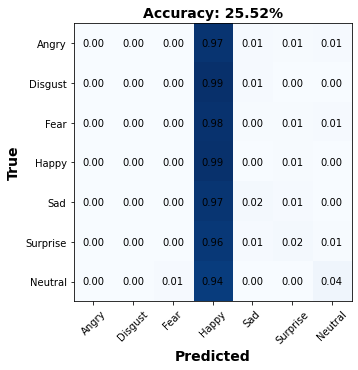

In [ ]:
generate_confusion_matrix(model, testset)

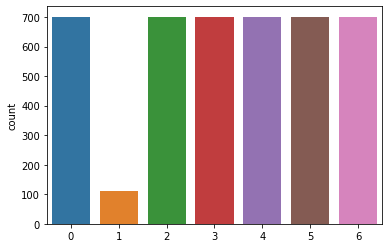

In [ ]:
# print the distribution of the classes in  the test set

def class_distribution(data) -> None:
    '''Print class distribution of the dataset'''
    labels = [label for _, label in data]
    sns.countplot(labels)
    plt.show()

class_distribution(testset)

In [ ]:
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
              ReLU-2          [-1, 128, 48, 48]               0
            Conv2d-3          [-1, 128, 48, 48]         147,584
              ReLU-4          [-1, 128, 48, 48]               0
       BatchNorm2d-5          [-1, 128, 48, 48]             256
         MaxPool2d-6          [-1, 128, 24, 24]               0
            Conv2d-7           [-1, 64, 24, 24]          73,792
              ReLU-8           [-1, 64, 24, 24]               0
            Conv2d-9           [-1, 64, 24, 24]          36,928
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 32, 12, 12]          18,464
             ReLU-14           [-1, 32,

TypeError: __str__ returned non-string (type NoneType)